## HealthSense v2

In [2]:
%%capture

!pip install imutils
!pip install super_gradients==3.0.7
!pip install albumentations 
!pip install split-folders[full]

In [4]:
import os
import math
import random
from typing import Dict, List,Tuple
import requests

import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path, PurePath
import pathlib
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
from torchvision import datasets
from torchvision import transforms

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

from imutils import paths

import splitfolders
import textwrap

import super_gradients
from super_gradients.common.object_names import Models
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.classification_metrics import Accuracy, Top5
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training import models
from super_gradients.training.utils.callbacks import Phase

# Number of classes

Simple utility to fetch the number of classes.

In [5]:
from pathlib import Path

def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)

# Example usage
parent_dir = "/kaggle/input/dataset/Dataset"
num_subdirectories = count_subdirectories(parent_dir)
print(f"Number of subdirectories in {parent_dir}: {num_subdirectories}")

Number of subdirectories in /kaggle/input/dataset/Dataset: 4


# Config Class

This  class holds variables for the notebook.

It defines the model, training params, image type, number of classes, and 
relevant directories in this class.

In [6]:
class config:
    # specify the paths to datasets
    DOWNLOAD_DIR = Path('/kaggle/input/dataset/Dataset')
    ROOT_DIR = Path('/kaggle/working/')
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('val')

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input heig/ht and width
    IMAGENET_MEAN = [0.50, 0.50, 0.50]
    IMAGENET_STD = [0.50, 0.50, 0.50]
    
    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 32
    MODEL_NAME = 'resnet50'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/imagenet_resnet50_train_params'
    
    NUM_CLASSES = num_subdirectories
    
    CHECKPOINT_DIR = 'checkpoints'

# Split data into training, validation and testing sets.

The data is not already split up into train, validation and test, so use the following split ratios.

The `ratio=(.8, .1, .1)` argument splits yhe data into 80% train, 10% validation, and 10% test.


In [7]:
splitfolders.ratio(config.DOWNLOAD_DIR, output=config.ROOT_DIR, seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 6400 files [00:50, 125.49 files/s]


# Plotting random images

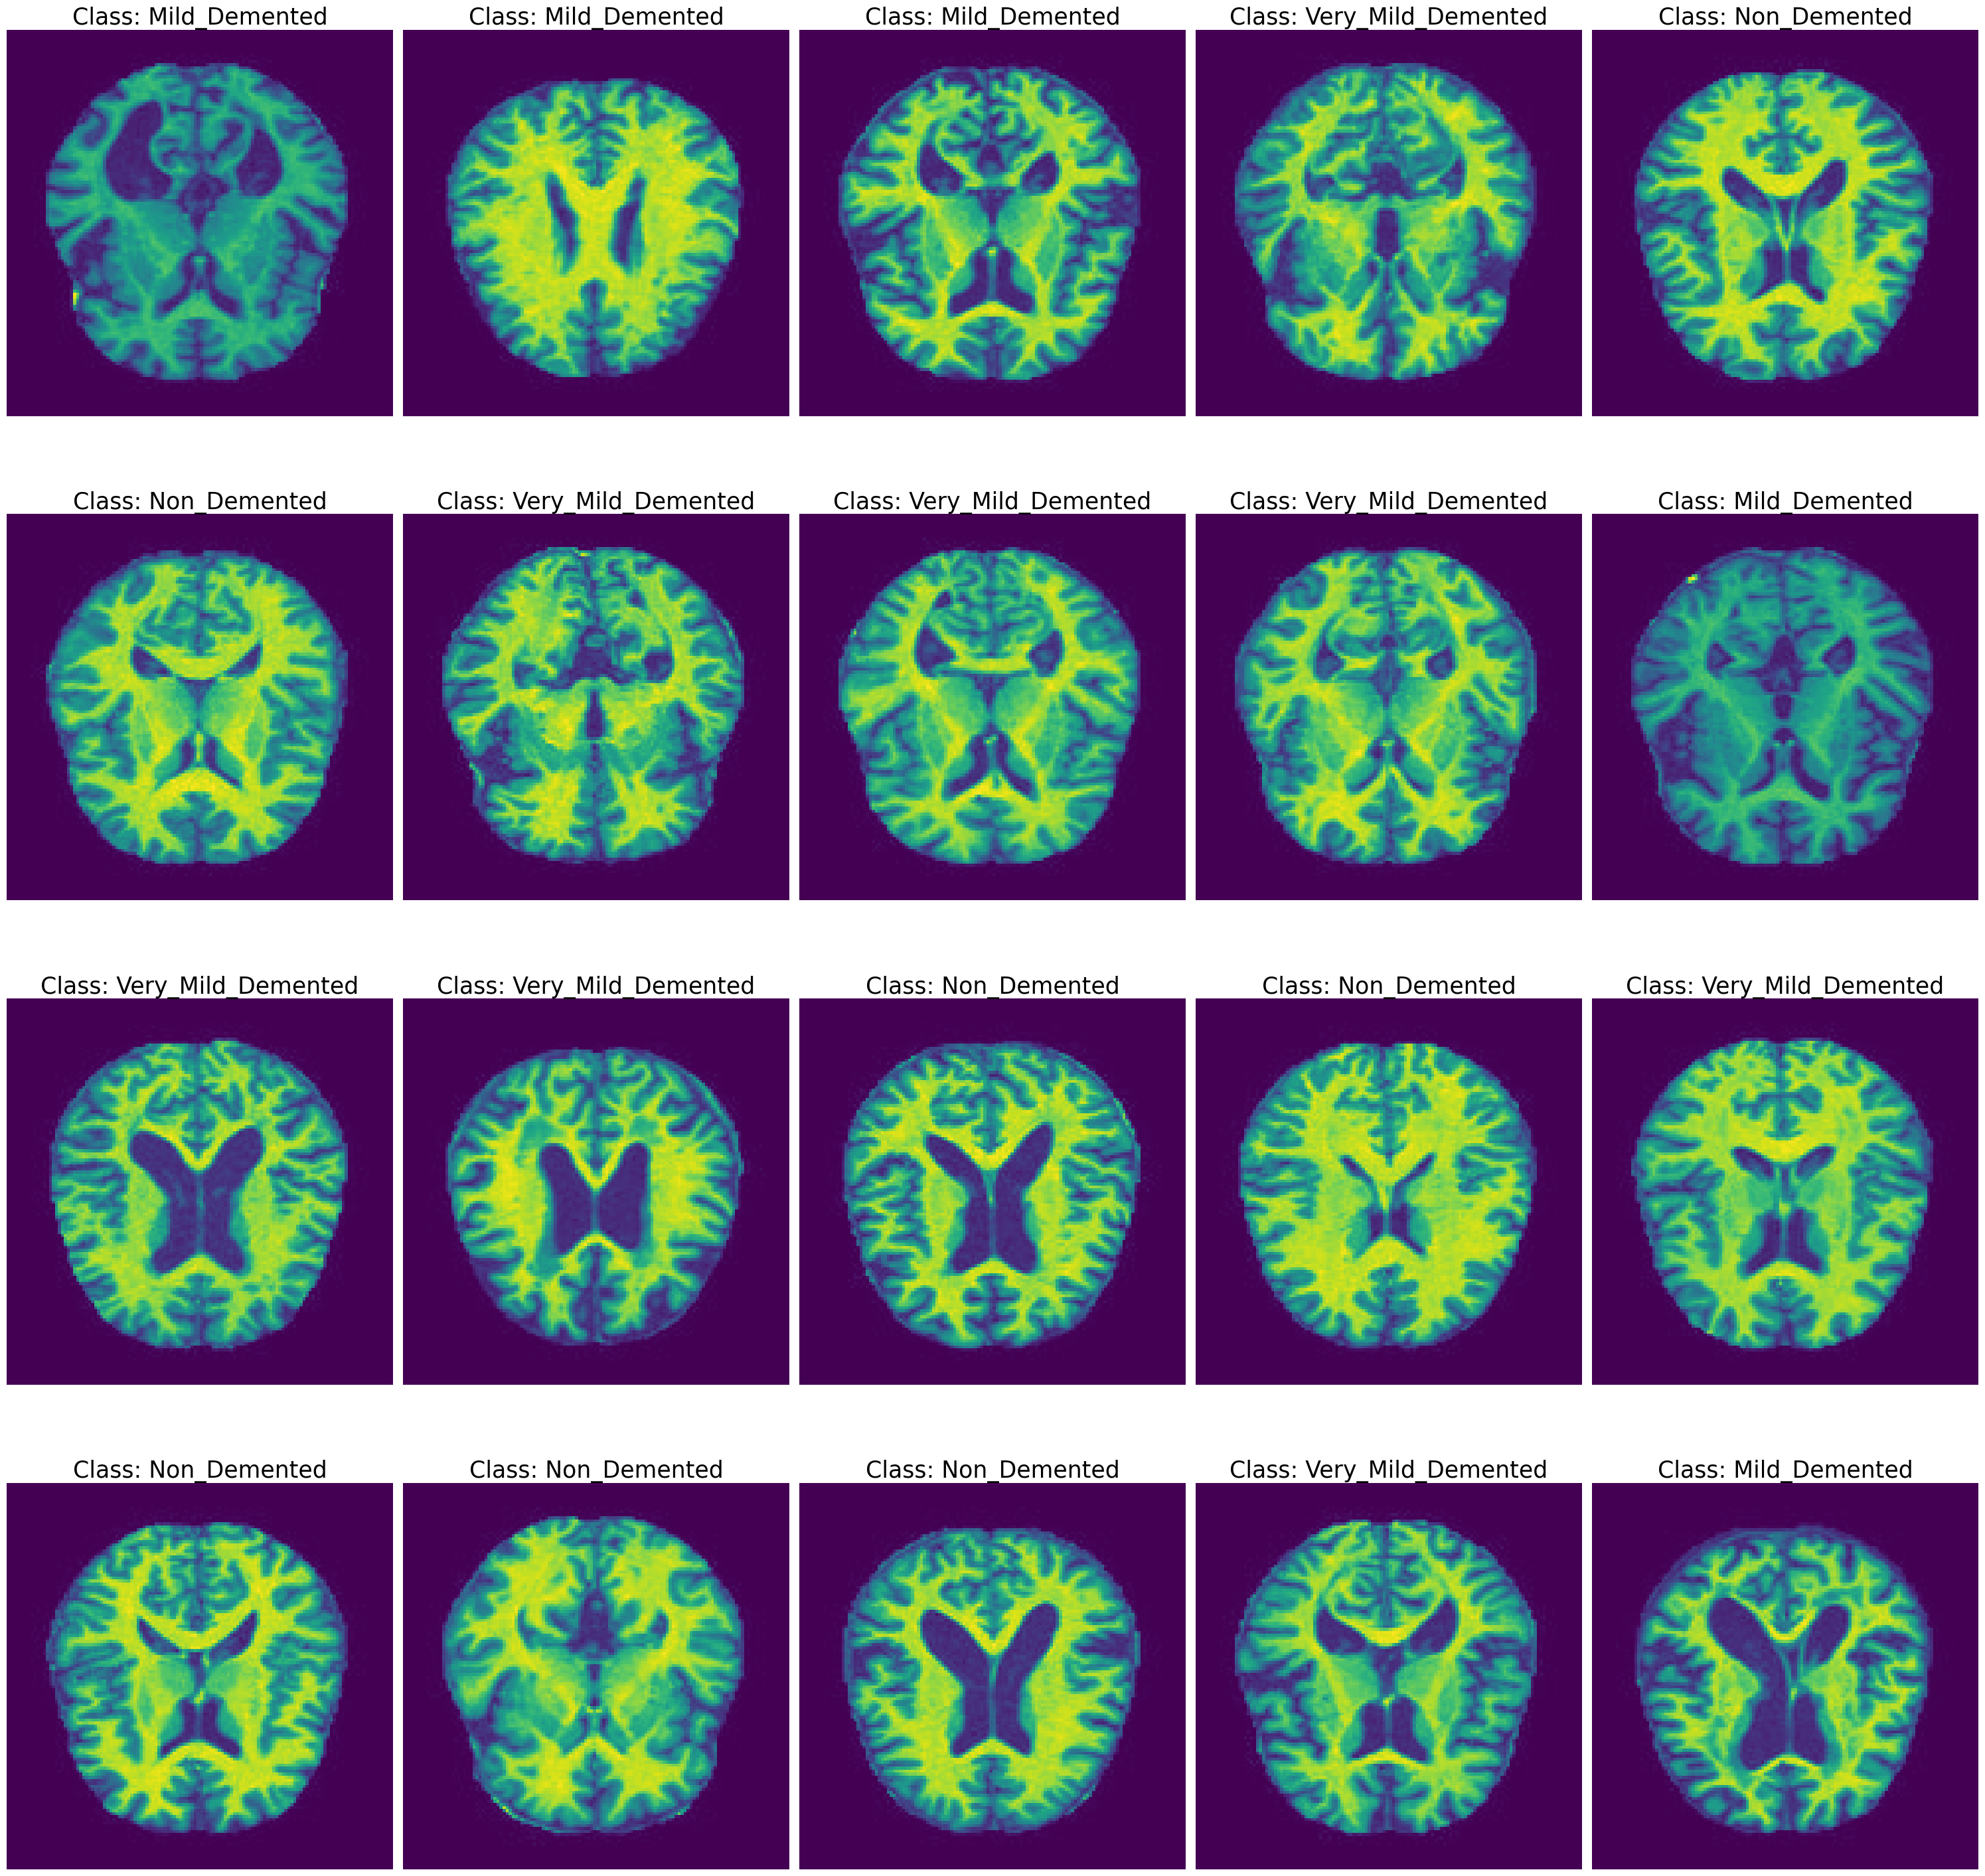

In [8]:
train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=20)

def examine_images(images:list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images/5))
    num_cols = 5
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30),tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Class: {label}", fontsize=25)
        axs[i].axis('off')
    plt.show()

examine_images(train_image_path_sample)

# Check for class distribution

We check for class distribution by plotting the number of images in each class. This helps us identifying imbalances (if any) between different classes of data.

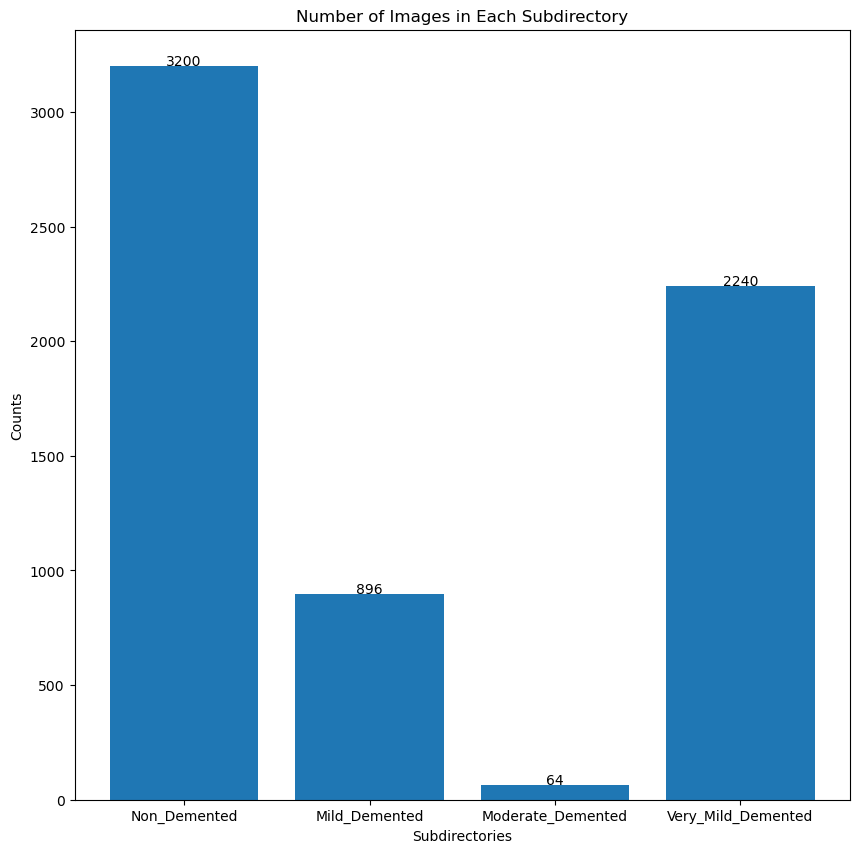

In [9]:
# Get a list of all subdirectories in the root directory
subdirs = [d for d in Path(config.DOWNLOAD_DIR).iterdir() if d.is_dir()]

image_count = {}

# Iterate through each subdirectory
for subdir in subdirs:
    subdir_images = list(sorted(paths.list_images(subdir)))
    image_count[subdir.name] = len(subdir_images)

# create a new figure with desired size
fig = plt.figure(figsize=(10, 10))

plt.bar(image_count.keys(), image_count.values())
# add the count numbers on top of the bars
for i, (subdir, count) in enumerate(image_count.items()):
    plt.text(i, count + 3, str(count), ha='center')

# set the title and labels for the plot
plt.title("Number of Images in Each Subdirectory")
plt.xlabel("Subdirectories")
plt.ylabel("Counts")

# show the plot
plt.show()

# Check Image mode

All the images in the dataset are in L mode (Luminosity Mode). L mode represents an image in grayscale and since most CNN/Deep learning models are designed to work with color images, it is important to convert the image from L mode to RGB mode before feeding it into the model.

In [10]:
image_types = {'path': [], 'mode': []}
# loop over all image files in the root directory and its subdirectories
for file_path in paths.list_images(config.ROOT_DIR):
    # open the image using PIL and get its mode
    with Image.open(file_path) as img:
        image_types['path'].append(file_path)
        image_types['mode'].append(img.mode)

# create a dataframe from the data
image_types_df = pd.DataFrame(image_types)
image_types_df['mode'].value_counts()

L    6400
Name: mode, dtype: int64

All of the images are in L mode, so we convert them all to RGB mode.


In [11]:
def convert_l_to_rgb(image_path):
  img = Image.open(image_path)
  rgb_img = Image.merge('RGB', (img, img, img))
  rgb_img.save(image_path)

# Loop over all image paths in the dataframe and convert if needed
for index, row in image_types_df.iterrows():
    if row['mode'] == 'L':
        convert_l_to_rgb(row['path'])

# Image Augmentations

Performing Image Augmentation to address the issue of imbalanced dataset by transforming the image through multiple augmentation functions. 


In [14]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
make_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
center_cropper = transforms.CenterCrop((config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.75)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.75)
random_rotation = transforms.RandomRotation(degrees=90)
random_crop = transforms.RandomCrop(size=(200,200))
augmix = transforms.AugMix(severity = 3, mixture_width=3, alpha=0.2)
auto_augment = transforms.AutoAugment()
random_augment = transforms.RandAugment()
# elastic_transformer = transforms.ElasticTransform(alpha=150.0)

# initialize our training and validation set data augmentation pipeline
train_transforms = transforms.Compose([
  resize, 
  random_augment,
  make_tensor,
  normalize
])

val_transforms = transforms.Compose([resize, random_augment, make_tensor, normalize])

# Dispaly image after augmentation

Let's get an idea of what an image looks like after the transformation pipeline.

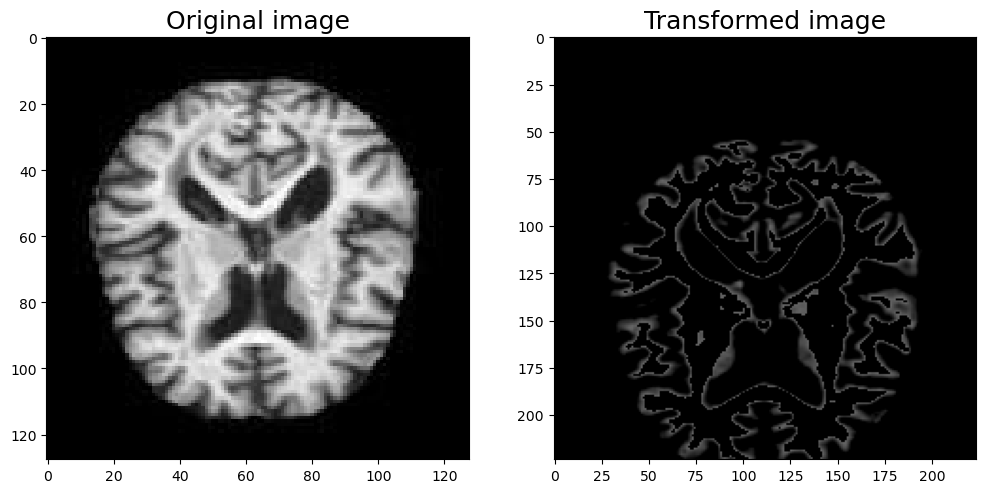

In [15]:
def apply_transform(img: Image, transform) -> np.ndarray:
    """
    Applies a transform to a PIL Image and returns a numpy array of the transformed image.

    Args:
        img (PIL.Image): The input image to transform.
        transform (torchvision.transforms.Compose): The transform to apply to the image.

    Returns:
        np.ndarray: A numpy array representing the transformed image.
    """
    # Apply the transform to the image
    if isinstance(transform, torchvision.transforms.Compose):
        # Apply PyTorch transform to image array
        transformed_image = train_transforms(img)

    elif isinstance(transform, A.Compose):
        # Apply Albumentations transform to image array
        img_array = np.array(img)
        transformed_image = transform(image=img_array)["image"]

    # Convert the image tensor to a numpy array and transpose the axes to (height, width, channels)
    img_array = transformed_image.numpy().transpose((1, 2, 0))

    # Clip the pixel values to the range [0, 1]
    img_array = np.clip(img_array, 0, 1)

    return img_array


def visualize_transform(image: np.ndarray, original_image: np.ndarray = None) -> None:
    """
    Visualize the transformed image.

    Args:
        image (np.ndarray): A NumPy array representing the transformed image.
        original_image (np.ndarray, optional): A NumPy array representing the original image. Defaults to None.
    """
    fontsize = 18
    
    if original_image is None:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the transformed image in the first column.
        ax[0].imshow(image)
    else:
        # Create a plot with 1 row and 2 columns.
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

        # Show the original image in the first column.
        ax[0].imshow(original_image)
        ax[0].set_title('Original image', fontsize=fontsize)
        
        # Show the transformed image in the second column.
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
img = Image.open(random.choice(train_image_path_list))
img_array = apply_transform(img, train_transforms)
visualize_transform(img_array, original_image=img)

# Datasets and Dataloader

In [16]:
"""Creating training and validation DataLoaders.
  Args:
    train_dir: Path to training data.
    val_dir: Path to validation data.
    transform: Transformation pipeline.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, val_dataloader, class_names)."""


def create_dataloaders(
    train_dir: str, 
    val_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    val_transform:  transforms.Compose,
    test_transform:  transforms.Compose,
    batch_size: int, 
    num_workers: int=2
):

  # Use ImageFolder to create dataset
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  val_data = datasets.ImageFolder(val_dir, transform=val_transform)
  test_data = datasets.ImageFolder(test_dir, transform=val_transform)  

  print(f"[INFO] training dataset contains {len(train_data)} samples...")
  print(f"[INFO] validation dataset contains {len(val_data)} samples...")
  print(f"[INFO] test dataset contains {len(test_data)} samples...")

  # Get class names
  class_names = train_data.classes
  print(f"[INFO] dataset contains {len(class_names)} labels...")

  # Turn images into data loaders
  print("[INFO] creating training and validation set dataloaders...")
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      drop_last=True,
      num_workers=num_workers,
      pin_memory=True,
      persistent_workers=True
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [17]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=config.TRAIN_DIR,
                                                                     val_dir=config.VAL_DIR,
                                                                     test_dir=config.TEST_DIR,
                                                                     train_transform=train_transforms,
                                                                     val_transform=val_transforms,
                                                                     test_transform=val_transforms,
                                                                     batch_size=config.BATCH_SIZE)

NUM_CLASSES = len(class_names)

[INFO] training dataset contains 5119 samples...
[INFO] validation dataset contains 639 samples...
[INFO] test dataset contains 642 samples...
[INFO] dataset contains 4 labels...
[INFO] creating training and validation set dataloaders...


# Training Paramaters

This is where we define all the hyperparameters for training.

Notice that we're using the AdamW optimizer. `optimizer_params= {}` simply means use the default parameters from PyTorch.

Utilizing exponential moving average. EMA essentially averages the model rates at each step using a coefficient. Thus, making the entire averaging exponential. At the beginning of the training, we would give a very high impact for the training weights. However, at each step, we would accumulate them to the existing weights each with a lower coefficient. 

In classification problems, sometimes our model predicts the training examples extremely confidently. 

This is not good for generalization, so we employed label smoothing cross entropy. Label smoothing encourages the representations of training examples from the same class to group in tight clusters.

Early stopping is enabled.

In [19]:
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)

In [20]:
early_stop_acc = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="Accuracy", mode="max", patience=7, verbose=False)
early_stop_val_loss = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="LabelSmoothingCrossEntropyLoss", mode="min", patience=7, verbose=False)

training_params["train_metrics_list"] = [Accuracy()]
training_params["valid_metrics_list"] = [Accuracy()]
training_params["phase_callbacks"] = [early_stop_acc, early_stop_val_loss]

# Set the silent mode to True to reduce clutter in the notebook, can turn it on to see the full output
training_params["silent_mode"] = True
training_params["optimizer"] = 'AdamW'
training_params['optimizer_params'] = {}
training_params['average_best_models'] = True
training_params['ema']= True
training_params["criterion_params"] = {'smooth_eps': 0.30}
training_params["max_epochs"] = 200
training_params["initial_lr"] = 0.0001

Notice that the training hyperparameters must be defined as a dictionary with the hyperparameter names as keys. The dictionary defines the hyperparameters that we want to override. All other hyperparameters retain their default values defined by SuperGradients. The list of all training hyperparameters and their default value can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).

# Get model

We are getting the model from the SuperGradients model zoo.

Three parameters are passed to the function:

`model_name` - A string defining the model's architecture name, out of the list of architectures SuperGradients provides.

`num_classes `- An integer representing the number of classes the model should learn to predict. Affects the architecture's structure.

`pretrained_weights` - A string defining the name of a dataset on which the model was pre-trained on, for fine-tuning and transfer learning. The pretrained_weights and checkpoint_path parameters are mutually exclusive.

In [21]:
model = models.get(config.MODEL_NAME, num_classes = config.NUM_CLASSES, pretrained_weights='imagenet')

Downloading: "https://deci-pretrained-models.s3.amazonaws.com/KD_ResNet50_Beit_Base_ImageNet/resnet.pth" to /root/.cache/torch/hub/checkpoints/KD_ResNet50_Beit_Base_ImageNet_resnet.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Instantiate trainer

We now have the implementation of all external components we wish to incorporate into our training pipeline.

First, we will initialize our trainer, which is in charge of training the model, evaluating test data, making predictions, and saving checkpoints. To initialize the trainer, we provide an experiment name, and a checkpoints root directory via the `ckpt_root_dir parameter`. In this directory, all of the experiment's logs, tensorboards, and checkpoint directories will reside.

In [25]:
full_model_trainer = Trainer(experiment_name='HealthSense', ckpt_root_dir=config.CHECKPOINT_DIR)

# Training the model

At the beginning of the training, a summary of the training parameters is printed, where we can see the training mode (CPU/single GPU/distributed training), the number of GPUs used, the training dataset size, and more. The progress of each epoch's training and validation is displayed, along with the tracked metrics (defined as part of the training recipe): accuracy, loss value, top5 error, and GPU memory consumption. 

At the end of each epoch, a summary of the training and validation metrics is displayed, and in later epochs, a comparison with the previous epochs is provided.


Since we are in `silent_mode` all that is printed is improvements in accuracy.

In [26]:
full_model_trainer.train(model=model, 
              training_params=training_params, 
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2023-04-16 16:32:00] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}


The console stream is now moved to checkpoints/HealthSense/console_Apr16_16_32_05.txt


[2023-04-16 16:32:08] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 5119       (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         159        (len(train_set) / total_batch_size)
    - Gradient updates per epoch:   159        (len(train_set) / effective_batch_size)

[2023-04-16 16:32:46] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/HealthSense/ckpt_best.pth
[2023-04-16 16:32:46] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5023474097251892
[2023-04-16 16:33:22] INFO - base_sg_logger.py - Checkpoint save

SUMMARY OF EPOCH 200
├── Training
│   ├── Accuracy = 0.9851
│   │   ├── Best until now = 0.988  (↘ -0.0029)
│   │   └── Epoch N-1      = 0.988  (↘ -0.0029)
│   └── Labelsmoothingcrossentropyloss = 0.799
│       ├── Best until now = 0.7964 (↗ 0.0025)
│       └── Epoch N-1      = 0.7964 (↗ 0.0025)
└── Validation
    ├── Accuracy = 0.9984
    │   ├── Best until now = 0.9937 (↗ 0.0047)
    │   └── Epoch N-1      = 0.989  (↗ 0.0094)
    └── Labelsmoothingcrossentropyloss = 0.7867
        ├── Best until now = 0.7887 (↘ -0.0019)
        └── Epoch N-1      = 0.7924 (↘ -0.0057)



[2023-04-16 16:51:55] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


# Get best model

Employing checkpoint averaging. This essentially averages the best performing model weights into a single model, which can improve generalization.

In [27]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(full_model_trainer.checkpoints_dir_path, "average_model.pth"))
# note if you're averaging the best model then replace "ckpt_best.pth" with "average_model.pth"

[2023-04-16 16:53:26] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/HealthSense/average_model.pth EMA checkpoint.


# Evaluate on test set

Notice that we achieve 99.07% on the test set.

In [28]:
full_model_trainer.test(model=best_model,
            test_loader=test_dataloader,
            test_metrics_list=['Accuracy'])

Test: 100%|██████████| 21/21 [00:01<00:00, 10.70it/s]


(0.79047, tensor(0.9953, device='cuda:0'))

# Plotting predictions

Plot some predictions from the test set.

In [30]:
import requests
def pred_and_plot_image(image_path: str, 
                        subplot: Tuple[int, int, int],  # subplot tuple for `subplot()` function
                        class_names: List[str] = class_names,
                        model: torch.nn.Module = best_model,
                        image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
                        transform: torchvision.transforms = None,
                        device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
      img = Image.open(image_path)
    else: 
      img = Image.open(requests.get(image_path, stream=True).raw)

    # create transformation for image (if one doesn't exist)
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.IMAGENET_MEAN,
                                 std=config.IMAGENET_STD),
        ])
    transformed_image = transform(img)

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = transformed_image.unsqueeze(dim=0)

        # make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # actual label
    ground_truth = PurePath(image_path).parent.name

    # plot image with predicted label and probability 
    plt.subplot(*subplot)
    plt.imshow(img)
    if isinstance(image_path, pathlib.PosixPath):
        title = f"Ground Truth: {ground_truth} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title("\n".join(textwrap.wrap(title, width=27)))  # wrap text using textwrap.wrap() function
    plt.axis(False)
    

def plot_random_test_images(model):
    num_images_to_plot = 30
    test_image_path_list = [pathlib.PosixPath(p) for p in sorted(paths.list_images(config.TEST_DIR))] # get list all image paths from test data 
    test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                           k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

    # set up subplots
    num_rows = int(np.ceil(num_images_to_plot / 5))
    fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    ax = ax.flatten()

    # Make predictions on and plot the images
    for i, image_path in enumerate(test_image_path_sample):
        pred_and_plot_image(model=model, 
                            image_path=image_path,
                            class_names=class_names,
                            subplot=(num_rows, 5, i+1),  # subplot tuple for `subplot()` function
                            image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH))

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=1)
    plt.show()

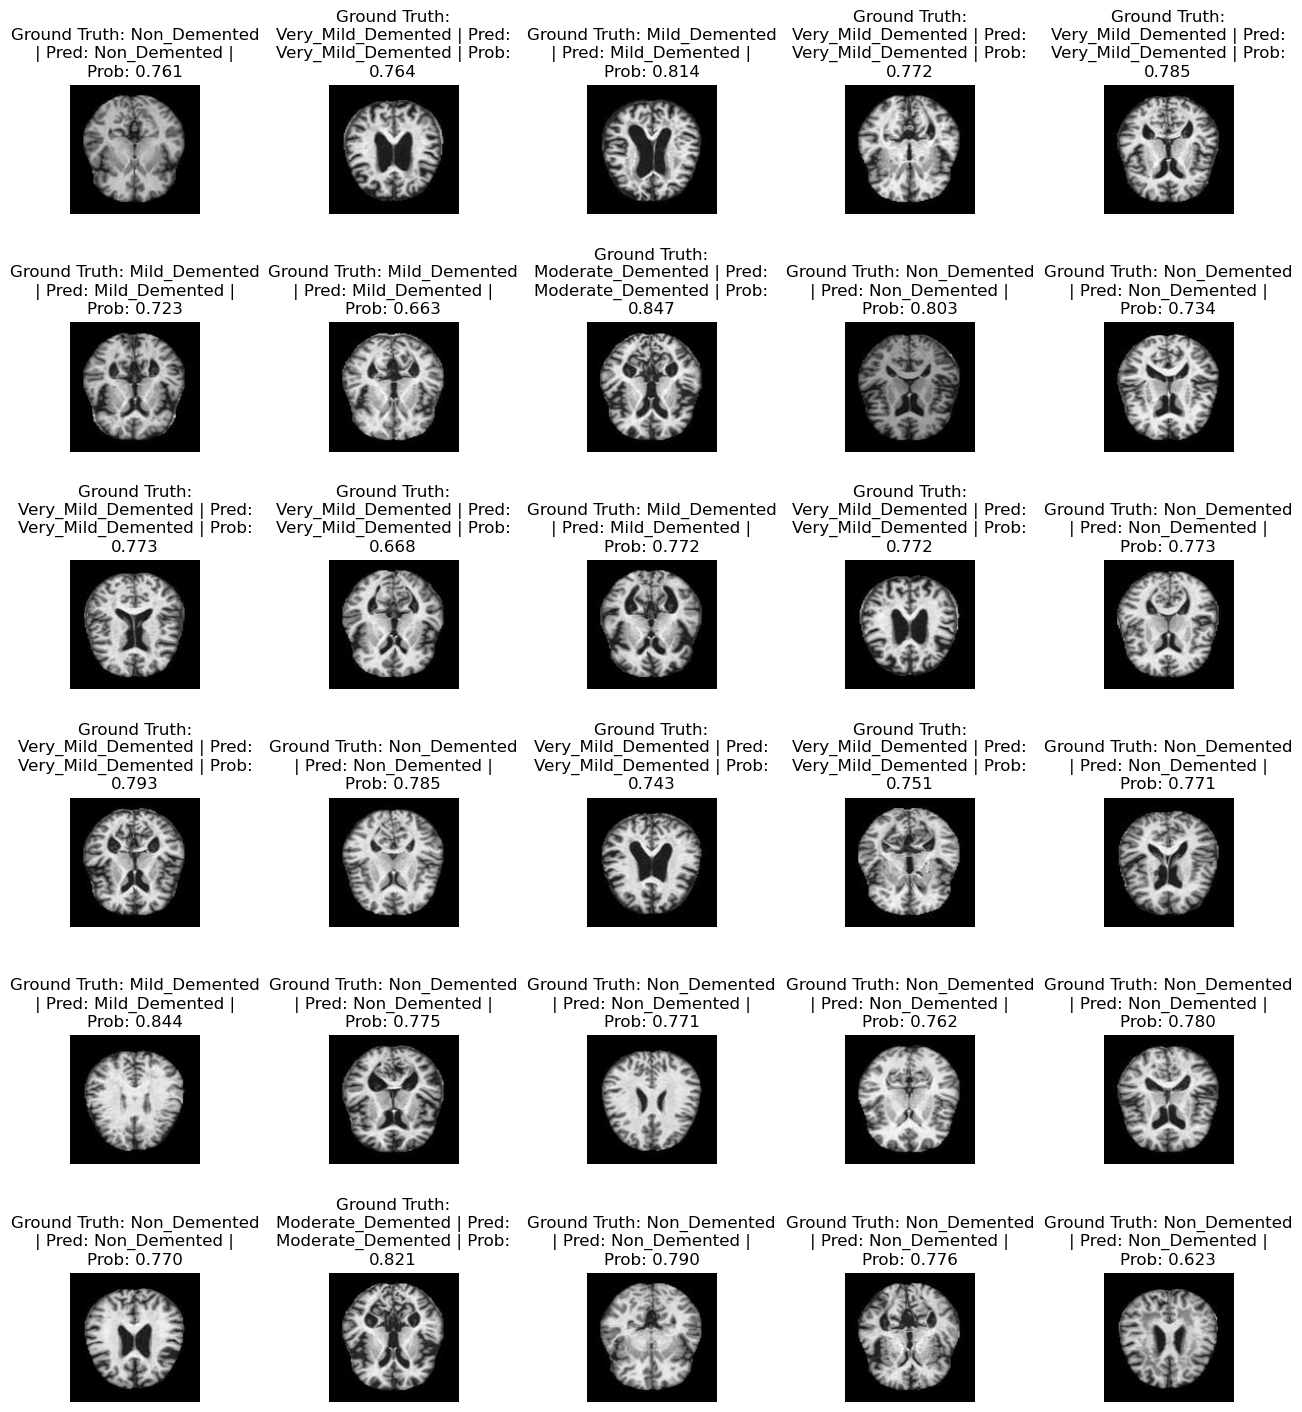

In [31]:
plot_random_test_images(best_model)

# Confusion matrix

The following code plots a confusion matrix.

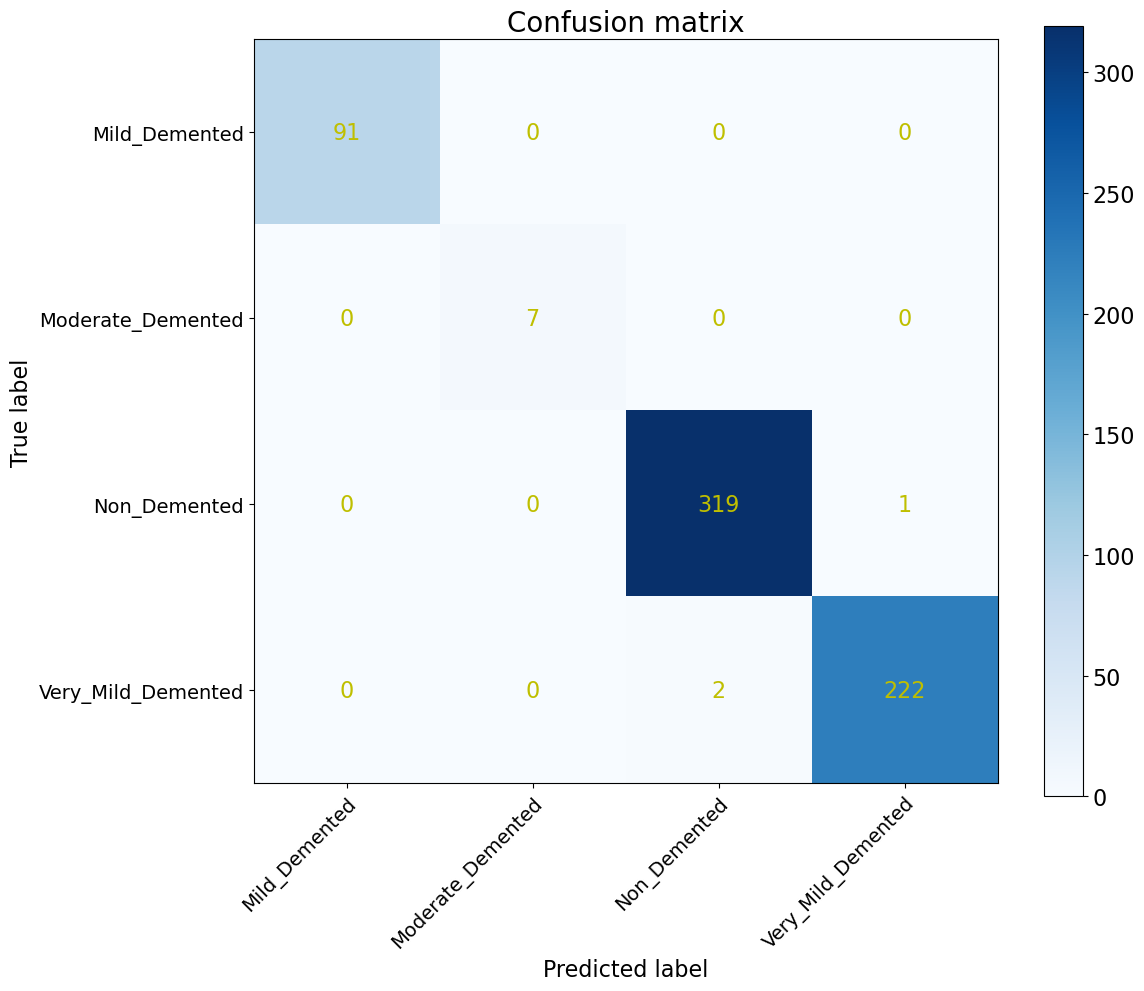

In [32]:
from sklearn.metrics import confusion_matrix

# Set model to evaluation mode
best_model.eval()

# Create empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Loop over batches in test dataloader, make predictions, and append true and predicted labels to lists
for images, labels in test_dataloader:
    images = images.to(config.DEVICE)
    labels = labels.to(config.DEVICE)
    with torch.no_grad():
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Calculate confusion matrix, precision, and recall
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create figure and axis objects with larger size and font size
fig, ax = plt.subplots(figsize=(12, 10))
plt.rcParams.update({'font.size': 16})

# Create heatmap of confusion matrix
im = ax.imshow(conf_matrix, cmap='Blues')

# Add colorbar to heatmap
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels and axis labels with larger font size
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=14)
ax.set_yticklabels(class_names, fontsize=14)
ax.set_xlabel('Predicted label', fontsize=16)
ax.set_ylabel('True label', fontsize=16)

# Rotate tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations to heatmap
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix[i, j] >= -1:  # Modify threshold value as needed
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="y", fontsize=16)
        else:
            text = ax.text(j, i, "",
                           ha="center", va="center", color="y")

# Add title to plot with larger font size
ax.set_title("Confusion matrix", fontsize=20)

# Show plot
plt.show()